In [1]:
%matplotlib inline

import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from IPython.display import Image

C:\Users\gorei\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Physics 5300 Final
By: Ishan Gore

## Problem 1: Double (and more) Pendulums

We can define the generalized coordinate for our double pendulum to be $\phi_1$ and $\phi_2$ according to the given picture below. Note that since $L_1$ and $L_2$ are constant, talking about the angles is enough for the generalized coordinates

In [2]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg')

### Euler-Lagrange equations

We first note that we are given the equations in the book for the Potential U (equation 11.37) and for the Kinetic Energy T (Equation 11.38).

Consequently, we have these energies to be

$\begin{align}
  U(\phi_1,\phi_2) = (m_1+m_2)gL_1(1-\cos(\phi_1)) + m_2gL_2(1-\cos(\phi_2))
\end{align}$ --- (11.37)

$\begin{align}
  T = \frac{1}{2}(m_1+m_2)L_1^2\dot{\phi_1}^2 + m_2L_1L_2\dot{\phi_1}\dot{\phi_2}\cos(\phi_1-\phi_2) + \frac{1}{2}m_2L_2^2\dot{\phi_2}^2
\end{align}$ --- (11.38)

With this we get our Lagrangian to be

$\begin{align}
  \mathcal{L} = \frac{1}{2}(m_1+m_2)L_1^2\dot{\phi_1}^2 + m_2L_1L_2\dot{\phi_1}\dot{\phi_2}\cos(\phi_1-\phi_2) + \frac{1}{2}m_2L_2^2\dot{\phi_2}^2 - (m_1+m_2)gL_1(1-\cos(\phi_1)) - m_2gL_2(1-\cos(\phi_2))
\end{align}$

Note that $\phi_1$ corresponds to $\theta_1$ in the picture and $\phi_2$ corresponds to $\theta_2$. We will use the $\phi$ variables as that is what the book uses

From this, we can create our Euler-Lagrance equations:

$\begin{align}
  \frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot{\phi_1}} = \frac{\partial \mathcal{L}}{\partial \phi_1} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
  \frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot{\phi_2}} = \frac{\partial \mathcal{L}}{\partial \phi_2}
\end{align}$

We can then use the substitution $z_i = \dot{\phi}_i$ and $\dot{z}_i = \ddot{\phi}_i$

Then after simplifying the above equations we get the following definitions for $z$ and $\dot{z}$:

$\begin{align}
\dot{z}_1 = \frac{m_2 g \sin(\phi_2) \cos(\phi_1-\phi_2) - m_2 \sin(\phi_1-\phi_2) [L_1 z_1^2 \cos(\phi_1-\phi_2) + L_2 z_2^2] - (m_1+m_2)g \sin(\phi_1)}
{L_1 * (m_1 + m_2\sin^2(\phi_1-\phi_2))}
\end{align}$

$\begin{align}
\dot{z}_2 = \frac{(m_1+m_2)[L_1 z_1^2 \sin(\phi_1-\phi_2) - g\sin(\phi_2) + g\sin(\phi_1)\cos(\phi_1-\phi_2)] + m_2 L_2 z_2^2 \sin(\phi_1-\phi_2) \cos(\phi_1-\phi_2)}
{L_2 * (m_1 + m_2\sin^2(\phi_1-\phi_2))}
\end{align}$

With these equations in hand we can now code up our system

In [3]:
class DoublePendulum():
    """
    Pendulum class implements the parameters and Lagrange's equations for 
     a simple pendulum (no driving or damping).
     
    Parameters
    ----------
    L1 : float
        length of the first pendulum
    L2 : float
        length of the second pendulum
    m1 : float
        mass of first pendulum
    m2 : float
        mass of second pendulum
    g : float
        gravitational acceleration at the earth's surface

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1., L2=1., m1=1., m2=1., g=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.m1 = m1
        self.m2 = m2
        self.g = g
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi_1(t), y[1] = dphi_1/dt and y[2] = phi_2(t), y[3] = dphi_2/dt
            
        Returns
        -------
        
        """
        phi1, z1, phi2, z2 = y
        
        L1, L2, m1, m2, g = self.L1, self.L2, self.m1, self.m2, self.g
        
        denom1 = L1*(m1+m2*(np.sin(phi1-phi2)**2))
        denom2 = L2*(m1+m2*(np.sin(phi1-phi2)**2))
        
        num1 = m2*g*np.sin(phi2)*np.cos(phi1-phi2) - m2*np.sin(phi1-phi2)*(L1*z1**2*np.cos(phi1-phi2)+L2*z2**2) - (m1+m2)*g*np.sin(phi1)
        num2 = (m1+m2)*(L1*z1**2*np.sin(phi1-phi2)-g*np.sin(phi2)+g*np.sin(phi1)*np.cos(phi1-phi2)) + m2*L2*z2**2*np.sin(phi1-phi2)*np.cos(phi1-phi2)
        
        z1_dot = num1/denom1
        z2_dot = num2/denom2
        
        
        return [z1, z1_dot, z2, z2_dot]
    
    def solve_ode(self, t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0, 
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi1_0, phi1_dot_0, phi2_0, phi2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi1, phi1_dot, phi2, phi2_dot = solution.y

        return phi1, phi1_dot, phi2, phi2_dot

In [4]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [5]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

With the functions coded up, let's make our graphs

In [6]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
m1 = 1.
m2 = 1.
g = 1.

# Instantiate a double pendulum 
dp1 = DoublePendulum(L1=L1, L2=L2, m1=m1, m2=m2, g=g)

#### Part a:
Here we make a graph for the $\phi$ values as a function of time

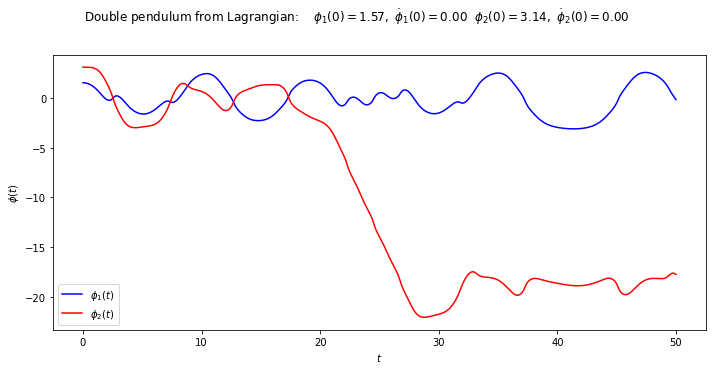

In [7]:
# initial conditions
phi1_0 = np.pi/2.
phi1_dot_0 = 0.
phi2_0 = np.pi
phi2_dot_0 = 0.
phi1, phi1_dot, phi2, phi2_dot = dp1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)


# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf'  $\phi_1(0) = {phi1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi1_dot_0:.2f}$' + \
                rf'  $\phi_2(0) = {phi2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi2_dot_0:.2f}$'
fig.suptitle(overall_title, va='baseline')
    

ax_a = fig.add_subplot(1,1,1)                  
# first plot: phi_1 plot
start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=rf'$\phi_1(t)$',
            ax=ax_a)
# first plot: phi_2 plot 
plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label=rf'$\phi_2(t)$', 
            ax=ax_a)

plt.legend()

fig.tight_layout()

We see that this plot appears to be correct, as it looks similar to the true graph shown in the hints video.

We can also make a similar graph for different initial conditions...

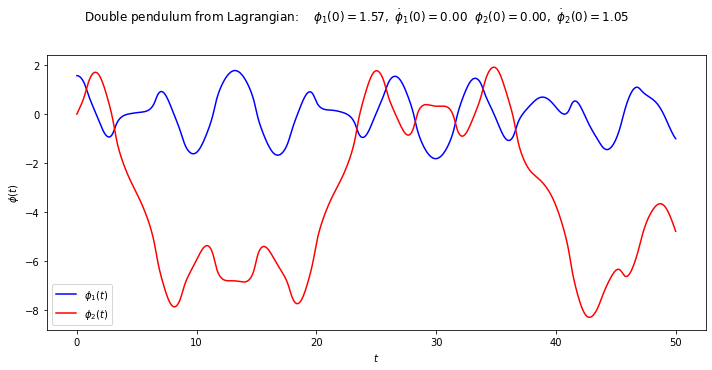

In [8]:
# initial conditions
phi1_0 = np.pi/2.
phi1_dot_0 = 0.
phi2_0 = 0.
phi2_dot_0 = np.pi/3.
phi1, phi1_dot, phi2, phi2_dot = dp1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)

# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf'  $\phi_1(0) = {phi1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi1_dot_0:.2f}$' + \
                rf'  $\phi_2(0) = {phi2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi2_dot_0:.2f}$'
fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(1,1,1)                  
# first plot: phi_1 plot
start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=rf'$\phi_1(t)$',
            ax=ax_a)
# first plot: phi_2 plot 
plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label=rf'$\phi_2(t)$', 
            ax=ax_a)

plt.legend()

fig.tight_layout()

#### Part b:
Now let's look at chaos by looking at $\Delta \phi$ when the initial conditions are slightly off

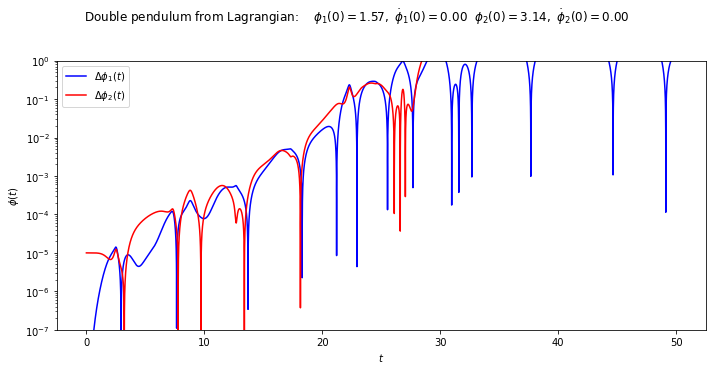

In [9]:
# initial conditions
phi1_0 = np.pi/2.
phi1_dot_0 = 0.
phi2_0 = np.pi
phi2_dot_0 = 0.

# two pendulums with slightly different initial conditions
phi1, phi1_dot, phi2, phi2_dot = dp1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)
phi1b, phi1_dotb, phi2b, phi2_dotb = dp1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0-0.00001, phi2_dot_0)

# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf'  $\phi_1(0) = {phi1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi1_dot_0:.2f}$' + \
                rf'  $\phi_2(0) = {phi2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi2_dot_0:.2f}$'
fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(1,1,1)                  
# first plot: phi_1-phi_1b plot
start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.abs(phi1[start : stop] - phi1b[start : stop]), 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=rf'$\Delta \phi_1(t)$',
            semilogy = True,
            ax=ax_a)
# first plot: phi_2-phi_2b plot 
plot_y_vs_x(t_pts[start : stop], np.abs(phi2[start : stop] - phi2b[start : stop]), 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label=rf'$\Delta \phi_2(t)$', 
            semilogy = True,
            ax=ax_a)

ax_a.set_ylim(1.e-7,1.)

plt.legend()

fig.tight_layout()

As we can see, the $\Delta \phi$ values seem to grow exponentially even with a very small deviation in the initial conditions. This indicates that the system is indeed chaotic.

#### Part e:
Let's animate the pendulums now!

In [26]:
from matplotlib import animation, rc
from IPython.display import HTML

In [27]:
# new time
t_pts = np.arange(0., 400., 0.05)

# initial conditions
phi1_0 = np.pi/2.
phi1_dot_0 = 0.
phi2_0 = np.pi
phi2_dot_0 = 0.

# two pendulums with slightly different initial conditions
phi1, phi1_dot, phi2, phi2_dot = dp1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)
phi1b, phi1_dotb, phi2b, phi2_dotb = dp1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0-0.00001, phi2_dot_0)

In [28]:
def xy_coords(x0, y0 , theta, L):
    """
    Converts from polar to cartesian coordinates
    """
    x = x0 + L*np.sin(theta)
    y = y0 - L*np.cos(theta)
    return x, y

In [29]:
%%capture
x_min = -3.2
x_max = -x_min
y_min = -3.2
y_max = -y_min

fig_anim = plt.figure(figsize=(5,5), num='Double Pendulum')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min, x_max)
ax_anim.set_ylim(y_min, y_max)

x0, y0 = 0., 0.
pt0_anim, = ax_anim.plot(x0, y0,
                        'o', markersize=6,
                        color='black')

x1, y1 = xy_coords(x0, y0, phi1[0], dp1.L1)
pt1_anim, = ax_anim.plot(x1, y1,
                        'o', markersize = 12,
                        color='blue')
ln1_anim, = ax_anim.plot([x0,x1], [y0,y1], color='blue', lw=3)
x2, y2 = xy_coords(x1, y1, phi2[0], dp1.L2)
pt2_anim, = ax_anim.plot(x2, y2,
                        'o', markersize = 12,
                        color='blue')
ln2_anim, = ax_anim.plot([x1,x2], [y1,y2], color='blue', lw=3)

x1b, y1b = xy_coords(x0, y0, phi1b[0], dp1.L1)
pt1b_anim, = ax_anim.plot(x1b, y1b,
                        'o', markersize = 12,
                        color='red')
ln1b_anim, = ax_anim.plot([x0,x1b], [y0,y1b], color='red', lw=3)
x2b, y2b = xy_coords(x1b, y1b, phi2b[0], dp1.L2)
pt2b_anim, = ax_anim.plot(x2b, y2b,
                        'o', markersize = 12,
                        color='red')
ln2b_anim, = ax_anim.plot([x1b,x2b], [y1b,y2b], color='red', lw=3)

ax_anim.set_aspect(1)
ax_anim.axis('off')
fig_anim.tight_layout()

In [30]:
def animate_pendulum(i):
    """ Function to create each frame i.
    """
    i_skip = 2*i
    
    x0,y0 = 0.,0.
    pt0_anim.set_data(x0,y0)
    
    x1,y1 = xy_coords(x0, y0, phi1[i_skip], dp1.L1)
    pt1_anim.set_data(x1,y1)
    ln1_anim.set_data([x0,x1],[y0,y1])
    x2,y2 = xy_coords(x1, y1, phi2[i_skip], dp1.L2)
    pt2_anim.set_data(x2,y2)
    ln2_anim.set_data([x1,x2],[y1,y2])
    
    x1b,y1b = xy_coords(x0, y0, phi1b[i_skip], dp1.L1)
    pt1b_anim.set_data(x1b,y1b)
    ln1b_anim.set_data([x0,x1b],[y0,y1b])
    x2b,y2b = xy_coords(x1b, y1b, phi2b[i_skip], dp1.L2)
    pt2b_anim.set_data(x2b,y2b)
    ln2b_anim.set_data([x1b,x2b],[y1b,y2b])
    
    return (pt0_anim, pt1_anim, ln1_anim, pt2_anim, ln2_anim,
           pt1b_anim, ln1b_anim, pt2b_anim, ln2b_anim)

In [31]:
frame_interval = 20.
frame_number = 1001
anim = animation.FuncAnimation(fig_anim,
                              animate_pendulum,
                              init_func=None,
                              frames=frame_number,
                              interval=frame_interval,
                              blit=True,
                              repeat=False)

In [32]:
HTML(anim.to_jshtml())

As we can see, the pendulums start almost identical, but after a short period of time they diverge completely without any noticable correlation at all, thus once again showcasing the system's chaos